## Data 620 - Final Project
### Fall 2017
#### Liam Byrne and Dmitriy Vecheruk
***
### Bitcoin Trading Price and Natural Language Processing

The value of cryptocurrencies, mainly Bitcoin ([BTC](https://coinmarketcap.com/currencies/bitcoin/)), have been extremely volatile since their inception. This volatility is spurred mainly by speculation, rumors and headlines. It would be an interesting use case of Natural Language Processing (NLP) to see how the cryptocurrency markets respond to news, rumor and overall sentiment; let's encapsulate all of these into sentiment for the sake of clarity. The result could be a gradation of the following:

1. Markets react to sentiment - *possible to capitalize on*
2. Sentiment is a reaction to the markets - *no use to capitalize on*
3. There is no correlation to either - *no use to capitalize on*

Moving forward, we will assume that **(1)** from above is how the markets react. In order to analyze this hypothesis, historical trading data from [BitStamp](https://www.bitstamp.net/) due to their medium trading volume. The [Twitter News feed](https://twitter.com/search?l=&q=Bitcoin%20OR%20BTC&src=typd) was scrapped using the search terms `Bitcoin OR BTC` between the dates of April 1, 2017, and December 15, 2017. April 1st was chosen as the starting point of our analysis due to it being the bottom of the market prior to the exponential take-off.

### Data Collection

A script was written, [TwitterBTC_GetData.py](https://github.com/Liam-O/Data620/blob/dev/FinalProject/TwitterBTC_GetData.py) to scrape historical Twitter News using a Twitter scraping package, [got3](https://github.com/Jefferson-Henrique/GetOldTweets-python) and the large trading data from BitStamp ([found here](http://api.bitcoincharts.com/v1/csv/)) was cleaned and substantially trimmed down.

***

### Loading Packages and Data

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
from IPython.display import display

# Matplotlib setup
from __future__ import print_function, division
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Plotly setup
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly import tools

# Make plotly work with Jupyter notebook
init_notebook_mode(connected=True)

### Bitcoin Trading Price

In [2]:
# BTC .pkl is on repo under /processed data... must clone to run
processed_path = "processed_data/bitstampUSD_processed_2017.pkl"
btc = pd.read_pickle(processed_path)

# Extract the date, add date time to index and cut out the end of 2016 
btc["date"] = btc.date_time.dt.date
btc.index = btc.date_time
btc = btc["2017"]

print(btc.shape)
btc.head()

(5803753, 5)


,timestamp,price,volume,date_time,date
date_time,,,,,
2017-03-31 20:00:31-04:00,1491004831,1071.34,0.010045,2017-03-31 20:00:31-04:00,2017-03-31
2017-03-31 20:00:31-04:00,1491004831,1071.34,0.019382,2017-03-31 20:00:31-04:00,2017-03-31
2017-03-31 20:00:52-04:00,1491004852,1070.53,0.029280,2017-03-31 20:00:52-04:00,2017-03-31
2017-03-31 20:00:56-04:00,1491004856,1070.31,0.108770,2017-03-31 20:00:56-04:00,2017-03-31
2017-03-31 20:01:12-04:00,1491004872,1070.93,0.200000,2017-03-31 20:01:12-04:00,2017-03-31


Taking a look at our data, we have ~5.8 million historical trades for BTC in 2017. Below we aggregate this trading data to build an open-high-low-close (OHLC) chart. 

In [3]:
# Add the time aggregation and OHLC funciton
def time_precision(series, precision):
    """
    Returns the date time series with a date time value floored to the 
    specified freq string
    """
    return (pd.DatetimeIndex(series)).floor(precision)


def make_ohlc(df, datetime_col, price_col, time_granularity):
    """
    Calculates the data for an OHLC chart from a df with a date_time and
    price columns, with intervals of time_granularity. Returns a DataFrame.
    """
    
    df = df.sort_values(datetime_col)    
    df["time_bracket"] = df[datetime_col].map(
        lambda x: time_precision(x, time_granularity))

    btc_ohlc = df.groupby("time_bracket")[price_col]\
        .agg(["first", "max", "min", "last", "median"])\
        .rename(columns={'first': 'open', 'max': 'high', "min": "low", "last": "close"})

    conditions = [(btc_ohlc['open'] <= btc_ohlc['close']),
                  (btc_ohlc['open'] > btc_ohlc['close'])]

    choices = ["up", "down"]

    btc_ohlc['price_change_label'] = np.select(conditions, choices)

    btc_ohlc["price_change_pct"] = 100 * \
        (btc_ohlc["close"] / btc_ohlc["open"] - 1)

    return (btc_ohlc)

btc_ohlc_24h = make_ohlc(btc,"date_time","price","1d")
btc_ohlc_6h = make_ohlc(btc,"date_time","price","6h")
btc_ohlc_6h.head(5)

btc = btc.sort_values("timestamp")
df = btc.groupby("date")["price"].agg(['mean']).rename(columns={'mean': 'price'})

start_date = "2017-04-01"
df = btc_ohlc_24h[pd.to_datetime(start_date).date():]

trace = go.Ohlc(x=df.index,
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.close,
               name = "BTC price")
data = [trace]
layout = dict(title = "Daily BTC price changes since "+start_date,
              yaxis = {'title': 'BTC Price USD'},legend=dict(orientation="h"))
fig = dict(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

We can see the volatility form the daily OHLC charts; from the min on April 1, when the price was ~ \$1K, to December 12, when the price was ~ \$17.5K. Below we will import the Twitter News tweets to venture a comparison between tweets and changing tradin price of Bitcoin. A 12-hour aggregated time interval will be used in order to make a comparison; specifically by the price change differential. An example of this BTC data is below.

In [4]:
time_aggr = "12h" ## Definition of the used time precision!
btc_ohlc = make_ohlc(btc,"date_time","price",time_aggr)
btc_ohlc.head(5)

,open,high,low,close,median,price_change_label,price_change_pct
time_bracket,,,,,,,
2017-03-31 12:00:00-04:00,1071.34,1076.84,1065.61,1069.15,1070.15,down,-0.204417
2017-04-01 00:00:00-04:00,1069.15,1097.00,1065.50,1073.65,1083.74,up,0.420895
2017-04-01 12:00:00-04:00,1073.68,1085.00,1061.64,1074.77,1073.04,up,0.101520
2017-04-02 00:00:00-04:00,1074.77,1089.00,1066.49,1089.00,1076.58,up,1.324004
2017-04-02 12:00:00-04:00,1089.00,1120.50,1071.12,1120.50,1088.00,up,2.892562


## Twitter News

Twitter News was used instead of the normal tweets due to a large volume of tweets from bots and tweets that seemed to be from scammers of marketers. Up to 1000 tweets/day were scrapped in order to analyze sentiment in order to collect enough tweets over a time-frame to compare it to the trading price of BTC as the results were returned with a mixture of popularity and most recent.

In [5]:
# Previous file used was "data/tweets2017.csv", the normal twitter feed
twt_path = "data/tweetnews_2017.csv"
twt = pd.read_csv(twt_path, encoding = "ISO-8859-1")
twt = twt.sort_values("timestamp")
twt["timestamp"] = pd.to_datetime(twt["timestamp"])
twt = twt[twt["timestamp"]>= pd.to_datetime("2017-01-01")]
print(twt.shape)
twt.head(10)

(182789, 2)


,tweet,timestamp
130,Investment Firm Will Use Bitcoin To Avoid US S...,2017-03-31 20:00:05
129,#Anarchist #Bitcoin Coder Amir Taaki Wound Up ...,2017-03-31 20:28:19
128,????????? Bitcoin ?Monacoin?????? - NAVER ??? ...,2017-03-31 21:04:50
127,How The Technology Behind Bitcoin Is Going To ...,2017-03-31 21:19:49
126,How an Anarchist Bitcoin Coder Found Himself F...,2017-03-31 21:51:09
125,Federal Reserve official warns of digital curr...,2017-03-31 22:08:03
124,Bitcoin : 'Blood Diamonds' Of The Digital Era ...,2017-03-31 22:13:59
123,A Plan to Save Blockchain Democracy From Bitco...,2017-03-31 22:18:00
122,Digital asset exchange ShapeShift raises $10.4...,2017-03-31 22:30:18
121,How Anarchist Bitcoin Coder Amir Taaki Wound U...,2017-03-31 22:32:14


Taking a closer look at some random tweets we see that a lot of them are stories of recent developments, marketing spam and rumor.

In [6]:
for t in twt.tweet[np.random.randint(0, len(twt), 10)]:
    print("\n"+t)


Litecoin Has Gained More Than 1500% This Year - Forbes: http:// ift.tt/2x9pnYi #bitcoin #btc

Bitcoin surges above $3K to record, more than tripling this year while ' bitcoin cash' struggles http:// ow.ly/6vkw30ecL9V via @CNBC

A small European nation is launching its own version of bitcoin http:// cnb.cx/2xc6Fx0

Cryptocurrencies: Many Similarities To Dot-Com Bubble - Winklevoss Bitcoin Trust ETF (Pending:COIN) | Seeking Alpha https:// seekingalpha.com/article/410621 7-cryptocurrencies-many-similarities-dot-com-bubble?source=email_rt_article_readmore&auth_param=2bhgl:1crgapf:6fe069e1abe65490d45ef945e72cc070&uprof=44 

The Art of Bitcoin s Millions. http:// buff.ly/2nj71Nz pic.twitter.com/jFUnC133pG

What's Next for Bitcoin After Digital Currency Split Is Averted https://www. bloomberg.com/news/articles/ 2017-07-21/what-s-next-for-bitcoin-after-digital-currency-split-is-averted  via @technology

Bitcoin Is Helping the Pot Business Get Over Its Banking Problem - http://www. potrepor

The tweets contain a lot of urls, different languages and repeat spams of tweets. We will clean the tweets in the following process and see the results of a randomized sample.

In [10]:
def isEnglish(s):
    """Checks if a string contains ASCII characters only.
    Source: https://stackoverflow.com/a/27084708/8066374
    """
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
# Clean the tweets
twt["tweet_proc"] = twt["tweet"].str.replace("https?://.*","") # remove all urls
twt["tweet_proc"] = twt["tweet_proc"].str.replace("’|","") # remove non-unicode apostrophe
twt = twt[twt["tweet_proc"].str.len() >= 3] # retain only the tweets with more than 3 remaining characters
twt["is_english"] = twt["tweet_proc"].map(isEnglish)

for t in twt.tweet_proc[np.random.randint(0, len(twt), 10)]:
    print("\n{}".format(t))


Tempted to buy bitcoin ? Block your phone and chain yourself up until the feeling goes away 

Wanker! 

Bitcoin is not the new gold, Goldman Sachs says 

From Here To Where? Bitcoin And The Future Of Cryptocurrency 

Prepare to bet against #bitcoin as it becomes civilised 

Hay una correlación del 91% entre busquedas de Bitcoin en Google y el precio de las Bitcoins 

Bitcoin boom prompts mining malware growth 

Bitcoin 's legendary rival is falling fast. You know that "weird cousin" vibe?... We're getting it from Etherium.... 

Fed's Kashkari: blockchain has more potential than bitcoin itself 

Bitcoin 's recent appreciation may largely be the result of new money entering the market 


As a final cleaning process, we will remove non-English tweets and drop duplicates prior to our sentiment analysis.

In [11]:
twt.groupby(["is_english"])["tweet"].count()

is_english
False     32086
True     147268
Name: tweet, dtype: int64

Remove ~32K tweets with non-ASCII characters to prepare the data for VADER sentiment analysis

In [12]:
twt_clean = twt[twt["is_english"]==True]
twt_clean = twt_clean.drop_duplicates("tweet_proc")
twt_clean = twt_clean.reset_index(drop = True)
twt_clean.shape

(79594, 4)

Only ~80k tweets remain after the cleaning step

#### Extract sentiment using NLTK and VADER

We will get the sentiment of the tweets regarding Bitcoin using the [Valence Aware Dictionary and sEntiment Reasoner (VADER) package](https://github.com/cjhutto/vaderSentiment). It gives a negative, neutral and compound score based on the tweets. We will look at some output to get an idea of how it works.

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

for t in twt.tweet_proc[np.random.randint(0, len(twt), 10)]:
    print("{}:\n{}\n".format(t, sid.polarity_scores(t)))

Bitcoin recovers much of post-CFTC tumble :
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Ray Dalio Calls Bitcoin a Bubble and a Highly Speculative Market :
{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'compound': 0.1761}

#bitcoin unter Druck: Streit um ein Software-Update für die Krypto-Währung :
{'neg': 0.302, 'neu': 0.698, 'pos': 0.0, 'compound': -0.5994}

Britain's largest broker offers bitcoin investment #bitcoin . @HLInvest :
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Bitcoin 's Next Battle May Already Be Looming :
{'neg': 0.406, 'neu': 0.594, 'pos': 0.0, 'compound': -0.4767}

Chinese bitcoin miners eye overseas move amid intensified scrutiny :
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Bitcoin split in two, here's what that means :
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

La France peut devenir la "Blockchain Nation" et gagner 5Mrd d' :
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Bitcoin surges past the $7,000 barrier again

In [14]:
# Append sentiment to tweets
twt_clean["sid"] = twt_clean["tweet_proc"].map(lambda x: sid.polarity_scores(x))
twt_clean = pd.concat([twt_clean.drop(["sid","tweet","is_english"], axis=1), 
                       twt_clean["sid"].apply(pd.Series)], axis=1)

#### Visualize the daily sentiment over time

Like the BTC trading data. We will aggregate the tweets over a 12 hour interval. We will plot the resulting time series. We aggregated the sentiment so the positive negative volume of sentiment could be reflected.

In [15]:
# Extract time components 
twt_clean["date_time"] = pd.to_datetime(twt_clean["timestamp"])

# Add the time granularity required for the join with the price data
twt_clean["time_bracket"] = (pd.DatetimeIndex(twt_clean["date_time"],
                                              tz = "America/New_York",
                                              ambiguous=False)).floor(time_aggr)

# Get daily total for the VADER scores
twt_clean_agg = twt_clean[["time_bracket","neg","pos","compound"]].groupby(["time_bracket"]).sum()
twt_clean_agg.head()

,neg,pos,compound
time_bracket,,,
2017-03-31 12:00:00-04:00,0.849,0.455,-0.8425
2017-04-01 00:00:00-04:00,3.317,4.314,2.2174
2017-04-01 12:00:00-04:00,2.051,2.809,1.2779
2017-04-02 00:00:00-04:00,1.928,1.762,-0.6084
2017-04-02 12:00:00-04:00,1.815,3.636,3.1380


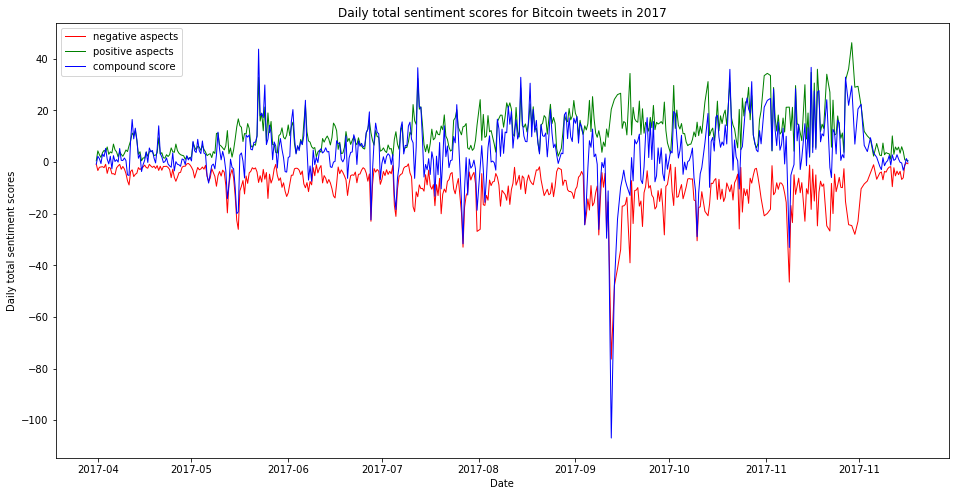

In [16]:
# Make a line plot
df = twt_clean_agg

plt.figure(num=1, figsize=(16, 8)) 
plt.plot(df.index, -df["neg"], linewidth=1,
         color="red", label=r"negative aspects")
plt.plot(df.index, df["pos"], linewidth=1,
         color="green", label=r"positive aspects")
plt.plot(df.index, df["compound"], linewidth=1,
         color="blue", label=r"compound score")
plt.xlabel(r"Date")
plt.ylabel(r"Daily total sentiment scores")
plt.title(r"Daily total sentiment scores for Bitcoin tweets in 2017")


# plt.plot(btc_daily_avg["date"], btc_daily_avg["price"], linewidth=1,
#          color="blue", label=r"daily avg price")

plt.legend(loc="upper left")

plt.show()

#### Correlate the daily compound sentiment with the price change direction

In [17]:
# Sentiment differential
twt_clean_agg["sent_diff"] = 0.0

for s in range(1, len(twt_clean_agg.index)):
    twt_clean_agg["sent_diff"][s] = np.float(twt_clean_agg["compound"][s]-twt_clean_agg["compound"][s-1])
    
twt_clean_agg.head()

,neg,pos,compound,sent_diff
time_bracket,,,,
2017-03-31 12:00:00-04:00,0.849,0.455,-0.8425,0.0000
2017-04-01 00:00:00-04:00,3.317,4.314,2.2174,3.0599
2017-04-01 12:00:00-04:00,2.051,2.809,1.2779,-0.9395
2017-04-02 00:00:00-04:00,1.928,1.762,-0.6084,-1.8863
2017-04-02 12:00:00-04:00,1.815,3.636,3.1380,3.7464


In [19]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

import datetime
'''
#Zoom timeline
format = '%Y-%m-%d %H:%M:%S'
start = datetime.date(2017, 4, 1) #enter 'None' to see all left
end = datetime.date(2017, 12, 16) #enter 'None' to see all right
'''
#Variables
twt_var = "compound"#"sent_diff"
btc_var = "price_change_pct"#close
'''
df1 = df1[(df1.index >= pd.to_datetime(start)) & (df1.index <= pd.to_datetime(end))]
df2 = df2[(df2.index >= pd.to_datetime(start)) & (df2.index <= pd.to_datetime(end))]
'''
#Force same y
twt_lim = max(abs(df1[twt_var]))
btc_lim = max(abs(df2[btc_var]))

trace1 = go.Scatter(x = df1.index, y = df1[twt_var], name = "sent")
trace2 = go.Scatter(x = df2.index, y = df2[btc_var], name = "btc", yaxis = "y2")

plot_data = [trace1, trace2]

layout = go.Layout(
    title='Twitter Sentiment and BTC Price',
    yaxis=dict(
        title='Sentiment',
        range = [-abs(max(df1[twt_var])),abs(max(df1[twt_var]))]
    ),
    yaxis2=dict(
        title='BTC price change (%)',
        range = [-abs(max(df2[btc_var])),abs(max(df2[btc_var]))],
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
    
fig = go.Figure(data = plot_data, layout = layout)
iplot(fig, filename = 'btc_sent')

In [20]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

import datetime
'''
#Zoom timeline
format = '%Y-%m-%d %H:%M:%S'
start = datetime.date(2017, 4, 1) #enter 'None' to see all left
end = datetime.date(2017, 12, 16) #enter 'None' to see all right
'''
#Variables
twt_var = "compound"#"sent_diff"
btc_var = "price_change_pct"#close
'''
df1 = df1[(df1.index >= pd.to_datetime(start)) & (df1.index <= pd.to_datetime(end))]
df2 = df2[(df2.index >= pd.to_datetime(start)) & (df2.index <= pd.to_datetime(end))]
'''
#Force same y
twt_lim = max(abs(df1[twt_var]))
btc_lim = max(abs(df2[btc_var]))

trace1 = go.Bar(x = df1.index, y = df1[twt_var], name = "sent",
               opacity = 0.6)
trace2 = go.Scatter(x = df2.index, y = df2[btc_var],
                    name = "btc", yaxis = "y2")

plot_data = [trace1, trace2]

layout = go.Layout(
    title='Twitter Sentiment and BTC Price',
    yaxis=dict(
        title='Sentiment',
        range = [-30,30]#[-max(abs(df1[twt_var])),max(abs(df1[twt_var]))]
    ),
    yaxis2=dict(
        title='BTC price change (%)',
        range = [-max(abs(df2[btc_var])),max(abs(df2[btc_var]))],
        overlaying='y',
        side='right'
    )
)
    
fig = go.Figure(data = plot_data, layout = layout)
iplot(fig, filename = 'btc_sent')

In the chart above it is hard to see a solid pattern of sentiment and BTC trading price. In some areas, large differential changes in sentiment has some affect on the price and in other areas it seems that there is no clear affect. We will analyze statistically to see if there is any correlation with using offsets.

In [21]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

btc_twt = pd.merge(df2.reset_index(),df1.reset_index(),"left")

# APlly time shifts
btc_twt["price_change_pct_prev_period"] = btc_twt["price_change_pct"].shift(1)
btc_twt["price_change_pct_next_period"] = btc_twt["price_change_pct"].shift(-1)

# Filter out the days with no twitter sentiment
btc_twt = btc_twt[btc_twt["compound"].notnull()]

Plot sentiments ~ price change (with shifts)

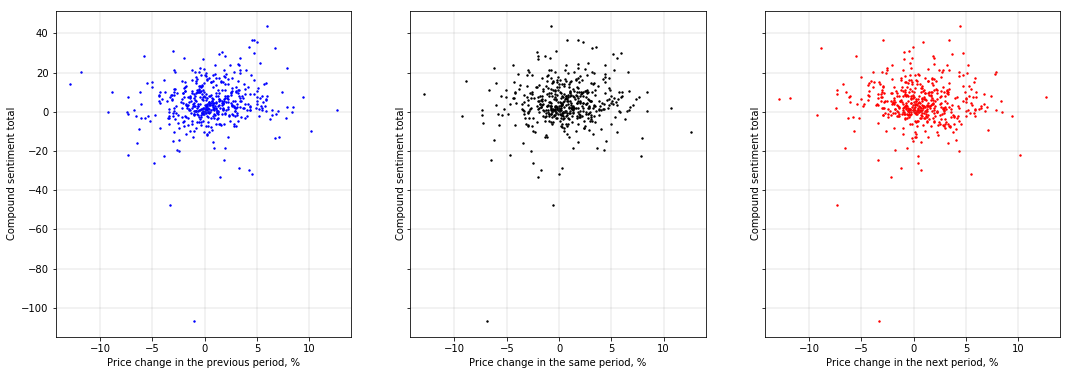

In [22]:
df = btc_twt

# fig, ax1 = plt.subplots(figsize=(8, 8))
fig, ((ax3, ax1, ax2)) = plt.subplots(1,3, sharex=True, sharey=True,figsize=(18, 6))

#Twitter variable
twt_var = "compound"
# axis label
twt_axis_label = dict(sent_diff = "Sentiment score change vs. past period",
                     compound = "Compound sentiment total")


ax1.scatter(df["price_change_pct"], df[twt_var], color="black",s=2)
ax1.set_xlabel('Price change in the same period, %')
ax1.set_ylabel(twt_axis_label[twt_var])
ax1.grid(color='grey', linestyle='-', linewidth=0.2)

ax2.scatter(df["price_change_pct_next_period"], df[twt_var], color="red",s=2)
ax2.set_xlabel('Price change in the next period, %')
ax2.set_ylabel(twt_axis_label[twt_var])
ax2.grid(color='grey', linestyle='-', linewidth=0.2)

ax3.scatter(df["price_change_pct_prev_period"], df["compound"], color="blue",s=2)
ax3.set_xlabel('Price change in the previous period, %')
ax3.set_ylabel(twt_axis_label[twt_var])
ax3.grid(color='grey', linestyle='-', linewidth=0.2)

plt.show()

### Check the correlations

In [23]:
correlations = btc_twt[["price_change_pct_prev_period","price_change_pct","price_change_pct_next_period",
         "sent_diff","compound","pos","neg"]].corr()

correlations.iloc[0:3,3:]

,sent_diff,compound,pos,neg
price_change_pct_prev_period,0.039145,0.107238,0.080822,-0.009726
price_change_pct,0.114288,0.089670,0.014326,-0.056928
price_change_pct_next_period,0.038748,-0.003285,-0.019471,-0.015318


We can see that the highest correlations between the price variables and sentiment variables are achieved between:
  
* the compound sentiment in the current period and the price change vs. the past period (r = +0.107)
* the change in sentiment and the price change in the current period (r = +0.114)

There does not seem to be any clear correlation. As a final analysis, we see that there is not even a clear correlation when the price differential is down or up and the distribution of sentiment.

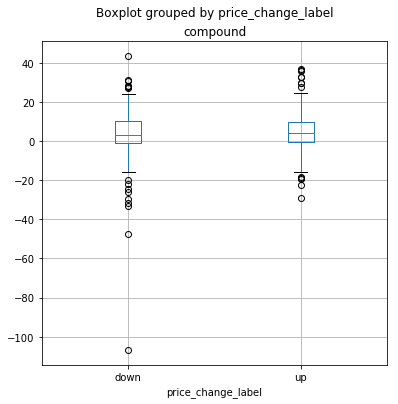

In [24]:
btc_twt.boxplot(column=twt_var,by='price_change_label',figsize=(6, 6))

### Word Frequency Analysis

Look at high frequency words when the price differential is large, to see if the could be word usage signals to buy or sell.

In [25]:
# Get 1000 largest price differences since 2017/4/1
btc_large_diff = btc_ohlc[pd.to_datetime("2017-04-01").date():]
btc_large_diff["abs_price_change_pct"] = btc_large_diff["price_change_pct"].abs()
btc_large_diff = btc_large_diff.nlargest(100, "abs_price_change_pct")

#Get start time of time frame
btc_large_diff["timestart"] = [t.replace(tzinfo = None) for t in btc_large_diff.index]

In [26]:
len(btc_ohlc_6h)

1025

In [27]:
twt_clean["future_price_diff"] = np.NaN

#Get future price change for respective tweet, if applicable
for t in twt_clean.index:
    if (btc_large_diff.timestart - twt_clean.date_time[t] <= pd.Timedelta('6 hours')).any():
        twt_clean["future_price_diff"][t] = btc_large_diff.price_change_pct[
            btc_large_diff.timestart - twt_clean.date_time[t] <= pd.Timedelta('6 hours')][0]

# Drop NaNs
twt_large_diff = twt_clean.dropna()

In [28]:
twt_large_diff.head()

,timestamp,tweet_proc,compound,neg,neu,pos,date_time,time_bracket,future_price_diff
3933,2017-05-03 18:00:40,"Bitcoin???168,000??????",0.0000,0.000,1.000,0.000,2017-05-03 18:00:40,2017-05-03 12:00:00-04:00,5.50413
3934,2017-05-03 18:00:44,"#Bitcoin soars to record high of $1,400 due to...",-0.1280,0.111,0.889,0.000,2017-05-03 18:00:44,2017-05-03 12:00:00-04:00,5.50413
3935,2017-05-03 18:01:48,#WhatsAppDown but #bitcoin going Up Up Up,0.0000,0.000,1.000,0.000,2017-05-03 18:01:48,2017-05-03 12:00:00-04:00,5.50413
3936,2017-05-03 18:18:05,Missing out on Bitcoin ? Price surges to all-t...,-0.2960,0.180,0.820,0.000,2017-05-03 18:18:05,2017-05-03 12:00:00-04:00,5.50413
3937,2017-05-03 18:26:52,"Exactly 2 ys old, ripe 4 update Argentina's ne...",0.4939,0.000,0.833,0.167,2017-05-03 18:26:52,2017-05-03 12:00:00-04:00,5.50413


We add domain-specific stop words to exclude from the frequency analysis (synonyms for "bitcoin" and the Twitter-specific term "RT" for retweet).

In [29]:
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *

domain_stop_words = ["bitcoin","btc","blockchain","cryptocurrency","currency","new","digital","rt"]

stop_words = set(nltk.corpus.stopwords.words('german') +\
           nltk.corpus.stopwords.words('english') + domain_stop_words)

twt_diff_up = twt_large_diff[twt_large_diff.future_price_diff > 0]
twt_diff_down = twt_large_diff[twt_large_diff.future_price_diff < 0]

# Clean then tokenize tweets. Also, remove stop words
# For "up" related tweets

twt_tokens_up = [nltk.tokenize.word_tokenize(t)
              for t in twt_diff_up["tweet_proc"].str.lower().replace(r'[^a-z\s]+','',regex=True)]
vocab_up = [item for sublist in twt_tokens_up for item in sublist if item not in stop_words]
fdist_up = nltk.FreqDist(vocab_up)

# For "down" related tweets
twt_tokens_down = [nltk.tokenize.word_tokenize(t)
              for t in twt_diff_down["tweet_proc"].str.lower().replace(r'[^a-z\s]+','',regex=True)]
vocab_down = [item for sublist in twt_tokens_down for item in sublist if item not in stop_words]
fdist_down = nltk.FreqDist(vocab_down)

def top_bigrams(vocab,n):
    """
    Calculates the top n most frequent bigrams 
    in the vocabulary. Returns a sorted list with bigram and
    normalized frequency.
    """
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    word_fd = nltk.FreqDist(vocab)
    bigram_fd = nltk.FreqDist(nltk.bigrams(vocab))
    finder = BigramCollocationFinder(word_fd, bigram_fd)
    scored = finder.score_ngrams(bigram_measures.raw_freq)
    
    return([(" ".join(bigram),score) for bigram,score in scored[:n]])   

def make_freq_df(list_of_tuples):
    """Makes a Pandas DF from an output of FreqDist"""
    
    df = pd.DataFrame(list_of_tuples,columns=["token","frequency"])
    df["tf"] = df["frequency"]/df["frequency"].max()
    df["prob"] = df["frequency"]/df.shape[0]
    
    return(df)

In [30]:
# Need to normalize by vocab length or by the % of the maximum
print(len(twt_tokens_up), len(twt_tokens_down))

3914 71747


In [31]:
top_bigrams(vocab_up,10)

[('first time', 0.009129154396297854),
 ('alltime high', 0.005511148506520825),
 ('past first', 0.004627681952040387),
 ('record high', 0.004585612116112747),
 ('market cap', 0.0036600757257046696),
 ('fresh record', 0.0030710980227177114),
 ('years ago', 0.002818679007151872),
 ('feds kashkari', 0.002229701304164914),
 ('surges record', 0.002187631468237274),
 ('ago youd', 0.0019772822885990747)]

In [32]:
top_bigrams(vocab_down,10)

[('record high', 0.0022791137355451098),
 ('via forbes', 0.0019014196979311),
 ('jamie dimon', 0.0017438673279549703),
 ('goldman sachs', 0.0016834362819367287),
 ('wall street', 0.0016553790105711165),
 ('alltime high', 0.0011762471457122015),
 ('business insider', 0.0011525063776336067),
 ('first time', 0.001040277292171158),
 ('need know', 0.0010014287625880027),
 ('hits record', 0.0006927987775662691)]

Take a look a frequency of word usage when the price is up or down.

In [33]:
freq_up = make_freq_df(fdist_up.most_common())
freq_down = make_freq_df(fdist_down.most_common())

freq_up[:10]

,token,frequency,tf,prob
0,high,315,1.000000,0.066218
1,first,289,0.917460,0.060753
2,record,285,0.904762,0.059912
3,time,263,0.834921,0.055287
4,ethereum,211,0.669841,0.044356
5,past,202,0.641270,0.042464
6,price,173,0.549206,0.036367
7,alltime,143,0.453968,0.030061
8,market,143,0.453968,0.030061
9,could,133,0.422222,0.027959


In [34]:
freq_down[:10]

,token,frequency,tf,prob
0,ethereum,3626,1.000000,0.115666
1,says,2921,0.805571,0.093177
2,bubble,2673,0.737176,0.085266
3,price,2639,0.727799,0.084181
4,cryptocurrencies,2294,0.632653,0.073176
5,high,2286,0.630447,0.072921
6,could,2237,0.616933,0.071358
7,gold,2226,0.613900,0.071007
8,via,2202,0.607281,0.070241
9,crypto,2118,0.584115,0.067562


In [35]:
# Make a chart with top words associated with UP and DOWN

df1 = freq_up[:20].sort_values("prob",ascending=True)
df2 = freq_down[:20].sort_values("prob",ascending=True)
x = "prob"
y = "token"
text = x

trace1 = go.Bar(
            x=df1[x],
            y=df1[y],
            text= (df1[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(0,255,120,0.5)',
            ),
            orientation = 'h',
            name = "Price increased"
        )
trace2 = go.Bar(
            x=df2[x],
            y=df2[y],
            text=(df2[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(255,0,0,0.5)',
            ),
            orientation = 'h',
            name = "Price decreased"
        )

fig = tools.make_subplots(rows=1, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(height=600, width=900, title='Top terms associated with BTC price increase/decrease \
<br>(sorted by relative frequency of ocurrence in tweets)',
                     legend=dict(orientation="h"))
fig['layout']["yaxis1"].update(tickfont=dict(size=14))
fig['layout']["yaxis2"].update(tickfont=dict(size=14))

iplot(fig, filename='simple-subplot')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



The word frequencies do not seem to show a clear pattern as some high frequency words are used when the price is up or down (e.g. Ethereum, high, fintech). On the other hand, there are some clear indicators for the price going up (e.g.: all-time, million surges, soars) and when it goes down (e.g.: china, bubble, Forbes). Some of these words could be used as indicators, but form a cursory look, it does not seem very promising as a trading tool.

As a final approach, we will look at bi-grams since single word usage probably have too much ambiguity.

In [36]:
# Make a chart with top bigrams
up_bigrams = make_freq_df(top_bigrams(vocab_up,20))
down_bigrams = make_freq_df(top_bigrams(vocab_down,20))

In [37]:
df1 = up_bigrams[:20].sort_values("frequency",ascending=True)
df2 = down_bigrams[:20].sort_values("frequency",ascending=True)
x = "frequency"
y = "token"
text = x

trace1 = go.Bar(
            x=df1[x],
            y=df1[y],
            text= (df1[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(0,255,120,0.5)',
            ),
            orientation = 'h',
            name = "Price increased"
        )
trace2 = go.Bar(
            x=df2[x],
            y=df2[y],
            text=(df2[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(255,0,0,0.5)',
            ),
            orientation = 'h',
            name = "Price decreased"
        )

fig = tools.make_subplots(rows=1, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(height=600, width=900, title='Top terms associated with BTC price increase/decrease\
<br>(sorted by relative frequency of ocurrence in tweets)',
                     legend=dict(orientation="h"),margin=dict(l=120))
fig['layout']["yaxis1"].update(tickfont=dict(size=14))
fig['layout']["yaxis2"].update(tickfont=dict(size=14))

iplot(fig, filename='simple-subplot')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



The bi-gram frequencies are more diverse than that of the mono-grams, but still have some ambiguity. do not seem to show a clear pattern as some high frequency words are used when the price is up or down (e.g. Ethereum, high, fintech). On the other hand, there are some clear indicators for the price going up (e.g.: all-time, million surges, soars) and when it goes down (e.g.: china, bubble, Forbes). Some of these words could be used as indicators, but form a cursory look, it does not seem very promising as a trading tool.

As a final approach, we will look at bi-grams since single word usage probably have too much ambiguity.

### Conclusions

From the data we were able to collect, there does not seem to be a clear correlation between Twitter sentiment and word usage in regards to the fluctuating price of Bitcoin. There could be numerous reasons for this. Some would include:

1. The data from Twitter was of poor quality
    + There appears to be a lot of spamming and bots on Twitter when it comes to Bitcoin and cryptocurrency as a whole. It is an unregulated market and the amount of people trying to capitalize on the volatility is large.
    + There was no way to filter the Twitter results. Results were mainly returned as most recent and we had to dive down deep into the daily feed in order to get earlier tweets from the day. In doing this, a lot of meaningless and inane tweets were collected in order to get to earlier periods in the day.
2. Bitcoin volatility is an irrational space spurred by irrational exuberance.
    + There seems to be two sides when it comes to cryptocurrency: those who believe in its future use cases or those who think it will go to zero. The terms "Internet 2.0" and "tulip mania 2.0" have been used for the believers and detractors, respectively. The detractors are not involved in the trading and therefore do not affect the demand for BTC.
3. VADER is not a good tool for sentiment analysis when it comes to tweets dealing with the financial realm.
    + VADER was trained and built around analyzing sentiment in social media posts. Things that are clear signals to be nervous as government, regulation, China and Wall Street could seem neutral in a social media post, but have a very clear indication in the cryptocurrency space.
    
The sentiment analysis did not give a strong correlation in predicting future changes to the trading price of Bitcoin, but the word frequency analysis appeared a little better in predicting the movement of the market. Overall, it seemed that when established institutions and people (e.g. Forbes, Goldman and Jamie Dimon) speak out on the future of Bitcoin, the market reacts slightly worse than when non-established institutions and people react. THe original investors and believers in the technology and future use cases for Bitcoin are in the market because they lean more anti-establishment than not. It seems that only time itself will show the future utility and value of Bitcoin; not the Twitterverse or the establishment.

### Reference

https://pandas.pydata.org/pandas-docs/stable/index.html

http://mple.m-artwork.eu/tutorial

Pandas Ifelse selection https://stackoverflow.com/a/19913845/8066374

NLTK & Vader http://www.nltk.org/howto/sentiment.html

Pandas dict to columns https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns

Matplotlib multiple axes https://matplotlib.org/examples/api/two_scales.html

Bigram analysis in NLTK http://www.nltk.org/howto/collocations.html

Plotly Reference https://plot.ly/python/

`Got` package issues board https://github.com/Jefferson-Henrique/GetOldTweets-python/issues?utf8=%E2%9C%93&q=